In [4]:
import math
import numpy
from matplotlib import animation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [5]:
"""
quaderature weights stay the same between all x grids in a subdomain, and all y grids in a subdomain
having this prevents having alot of copy pasted code
#NOTE: go through and replace a bunch of stuff with numpy 2darrays instead of lists

"""
class quadWeights:
    def __init__(self, alpha , h ):
            self.alpha_ = alpha
            self.h_     = h
            
            self.vj_    = self.alpha_*self.h_
            self.dj_    = math.exp(-self.vj_) 
            
            ratio = (1-self.dj_)/self.vj_
            eps = 1e-3
            self.Q_     = -self.dj_ + ratio

            #if things get small, this blows up 
            if self.vj_>eps:
                self.P_ = 1 - ratio
                self.R_ = 1-self.dj_-self.vj_/2*(1+self.dj_ )
            else:
                self.P_ = (self.h_/2-self.h_**2/6+self.h_**3/24-self.h_**4/120)
                self.R_ = -math.exp(-self.h_/2)*(self.h_**3/12+self.h_**5/480+self.h_**7/53760)

In [6]:
"""
This class stores 2d segments of our wave solver, note that it doesn't solve anything, just stores
X , Y , U and a bunch of parameters that get passed to a 1d solver

rectlist = [xa , xb , ya , yb , N]
    xa  the starting xvalue of the subdomain
    xb  the ending xvalue of the subdomain
    ya  the starting yvalue of the subdomain
    yb  the ending yvalue of the subdomain
    N   the number of points in 1-dimension (there will be N^2 points)
f   function describing the initial state  (currently radial )
g   function describing the initial derivative in time  (currently radial)
c   speed of wave propogation
cfl time propogation length factor
dt  time step length

"""
class rectSegment:
    def __init__(self , rectlist, f , g, c , cfl):
        self.xa_ = rectlist[0]
        self.xb_ = rectlist[1]
        self.ya_ = rectlist[2]
        self.yb_ = rectlist[3]
        self.N_  = rectlist[4]
        self.c_  = c
        
        self.beta_ = 2
        
        self.x_ = numpy.linspace(self.xa_ , self.xb_ , self.N_)
        self.y_ = numpy.linspace(self.ya_ , self.yb_ , self.N_)
        
        self.dx_ = self.x_[1] - self.x_[0]
        self.dy_ = self.y_[1] - self.y_[0]
        
        self.X_ , self.Y_ = numpy.meshgrid(self.x_ , self.y_)
        
        #w is the intermediate solution
        self.w_ = numpy.zeros((self.N_,self.N_))
        
    """time steps cannot be determined until all subgrids are made"""
    def setTimestep(self , dt):
        self.dt_ = dt
        self.alpha_ = self.beta_/(self.c_*self.dt_) 
        self.xquadWeights_ = quadWeights(self.alpha_ , self.dx_ )
        self.yquadWeights_ = quadWeights(self.alpha_ , self.dy_ )

        self.taylorStep( f , g )
       
    """get the minimum spatial step size"""
    def getMinStep( self ):
        return min(self.dx_,self.dy_)
    
    """step forward once in time using a different method (in this case a taylor series)"""
    def taylorStep( self , f , g ):
        N = self.N_
        self.ucurr_ = numpy.zeros((N,N))
        self.uprev_ = numpy.zeros((N,N))
        
        for  xindex, x in enumerate(self.x_):
            
            
            for yindex , y in enumerate(self.y_):
                self.uprev_[yindex,xindex] = f( x , y )
                self.ucurr_[yindex,xindex] = f(x , y) + self.dt_*g( x , y )
    
    """return a specific row"""
    def getRow( self , rowNo ):
        return lineSegment( self.x_ , self.w_[rowNo] , self.uprev_[rowNo] , self.xquadWeights_ , self.alpha_)
    
    """make a line segment for a specific column"""
    def getCol(self , colNo ):

        columnUs = [w[colNo] for w in self.ucurr_ ]
        #print(columnUs)
        columnPrevs = [uprev[colNo] for uprev in self.uprev_]
        
        return lineSegment (self.y_ , columnUs , columnPrevs , self.yquadWeights_ , self.alpha_ )
    
    def storeIntermSoln( self , col , intermSoln):
        for rowIndex , row in enumerate(self.w_):
            row[col] = intermSoln[rowIndex]
    
    def updateSoln( self , row , newSoln):
        self.uprev_[row] = self.ucurr_[row]
        self.ucurr_[row] = newSoln
 
    def plotSoln( self , ax):
        surf = ax.plot_surface(self.X_, self.Y_ ,self.ucurr_,rstride=2, cstride=2, shade=False, cmap="jet", linewidth=1)
        surf.set_edgecolors("black")
        surf.set_facecolors(surf.to_rgba(surf._A))

In [7]:
"""
class that does the 1d domain computations, slices of the 2d rectangles will be turned into
into these line segments 
"""
class lineSegment:
    def __init__( self , xvals , ucurr , uprev , quadweights , alpha):
        self.xvals_ = xvals
        
        self.beta_ = 2
        self.ucurr_ = ucurr
        self.uprev_ = uprev
        
        self.quadweights_ = quadweights
        self.a_ = xvals[0]
        self.b_ = xvals[-1]
        self.alpha_ = alpha

    
    def __len__(self):
        return len(self.xvals_)
    
    """
    calculate the local contribution of the solution and report the endpoints
    THIS WILL LIKELY BE THE THING TO PARALLELIZE
    """        
    def calcLocalContribution( self ):
        uvals = self.ucurr_

        quadCoeffs = []  
        size = len(self.xvals_)
        
        quadweights = self.quadweights_
        
        JLval = [0]
        JRval = [0]
        
        #do a finite difference stencil for the second derivative at every point
        #in our mesh. do a 4 point stencil at the ends to preserve accuracy
        for i in range(size):
            if i != 0 and i != (size-1):
                quadCoeffs.append((uvals[i-1] - 2*uvals[i] + uvals[i+1])*1/quadweights.vj_**2 )
            elif i == 0:
                quadCoeffs.append((2*uvals[0] - 5*uvals[1] + 4*uvals[2] - uvals[3])*1/quadweights.vj_**2 )
            else:
                quadCoeffs.append((2*uvals[-1] - 5*uvals[-2] +4*uvals[-3] - uvals[-4])*1/quadweights.vj_**2)
            #evaluate the polynomial integral for each J between 0 and N.
        for j in range(size):

            if j != 0:
                #recursive formula to update the value of J
                JLcurr  = quadweights.P_*uvals[j] + quadweights.Q_*uvals[j-1] + quadCoeffs[j]*quadweights.R_
                JLval.append( quadweights.dj_*JLval[j-1] + JLcurr )

            if j != size-1:
                JRreverse = quadweights.P_*uvals[-(j+2)]+quadweights.Q_*uvals[ -(j+1) ] + quadweights.R_*quadCoeffs[-(j+2)] 
                JRval.append(quadweights.dj_*JRval[j] + JRreverse)
        JRval.reverse()
        
        self.w_ = [.5*(JLval[i]+JRval[i]) for i in range(size)]
        
        return self.reportEndPoints()
    
    """helper function"""
    def getAlphaDistance(self):
        return self.alpha_*(self.b_-self.a_)
    
    
    """pass the end points of the segment up to the global solver"""
    def reportEndPoints(self):
        return [self.w_[0] , self.w_[-1]]
    
    """update the solution with the endpoints from it's neighbors(or boundaries)"""
    def updateSoln(self , Am ,Bm):
        size = len(self.xvals_)
        self.u_ = [0]*size
        print(Am,Bm)
        for i in range(size):
            self.u_[i] = (self.w_[i]+Am*math.exp(-self.alpha_ *(self.xvals_[i] -self.a_ ) ) + Bm*math.exp(-self.alpha_ *(self.b_  - self.xvals_[i])))
    """report the solution at a given timestep"""
    def getSoln(self):
        return self.u_
    
    """after ALL other calculations are done,  """
    def calcFinalSoln(self):
        size = len(self.xvals_)
        
        for i in range(size): 
            self.u_[i] = 2*self.ucurr_[i] - self.uprev_[i] + self.beta_**2*(self.u_[i]-self.ucurr_[i])


In [11]:
"""
class lineSolve, does all of the 1D subdomain calculations, passes them back to the line segments

lineSegments a list of lineSegment objects
bcType       what type of boundary conditions to apply

"""
class lineSolve:
    def __init__(self , lineSegments , bcType):
        self.bcType_   = bcType
        self.segments = lineSegments
        self.segmentLen = len(lineSegments)
        
        self.leftComm_   = []
        self.rightComm_  = []
        self.Ileft_      = [0]
        self.Iright_     = [0]
        
        self.damping_ = 1
        
        for segment in self.segments:
            self.damping_ *= math.exp(-segment.getAlphaDistance())

    """
    waveHandler should know about the BC's, segments shouldn't have any idea
    what the boundary conditions are, this will set the correct bc conditions
    """
    def applyBCs(self, leftEnds , rightEnds):
        self.BC1_ = 0#2*leftEnds/(1-self.damping_)
        self.BC2_ = 0#2*rightEnds/(1-self.damping_)
    
    """do local contributions for each segment, and then calculate """
    def propogate(self):
        #need to reset the 'memory'
        self.leftComm_  = []
        self.rightComm_ = []
        
        self.A_    = [0]
        self.B_    = [0]    
        #BCends = [ 0 , 0]
        
        #calculate local contributions, and report the end points
        for segmentIndex in range(self.segmentLen):
            segment   = self.segments[segmentIndex]
            
            endpoints = segment.calcLocalContribution()

            self.leftComm_.append(endpoints[0])
            self.rightComm_.append(endpoints[1])

            
        JL = self.rightComm_[0]
        JR = self.leftComm_[-1]
        
        distanceScalar = 1
        
        for segmentIndex in range(self.segmentLen-1):
            segment  = self.segments[segmentIndex]
            expAlphaDistance = math.exp(-segment.getAlphaDistance())
            
            self.A_.append(JL)
            self.B_.append(JR)
            
            distanceScalar*=expAlphaDistance
            
            JL = JL*distanceScalar + self.rightComm_[segmentIndex+1]
            JR = JR*distanceScalar + self.leftComm_[segmentIndex]
        
        
        
        self.applyBCs(JL,JR)
        
        distanceScalar = 1
        for segmentIndex , segment in enumerate(self.segments):
            self.A_[segmentIndex] += distanceScalar*self.BC1_
            self.B_[segmentIndex] += distanceScalar*self.BC2_

            expAlphaDistance = math.exp(-segment.getAlphaDistance())
            distanceScalar *=expAlphaDistance
        
        self.B_.reverse()
        for segmentIndex in range(self.segmentLen):
            currSegment  = self.segments[segmentIndex]
            currSegment.updateSoln(self.A_[segmentIndex], self.B_[segmentIndex])
        
        
        self.meshSolns()
    def meshSolns(self):
        self.allSolns_ = []
        endpointSwitch = True 
        #to properly mesh grids together
        #if it's even, then take the left endpoint off 
        #if it's odd, then take the right endpoint off
        for segment in self.segments:
            if(endpointSwitch):
                self.allSolns_+=segment.getSoln()[0:len(segment)-1]
                endpointSwitch = False
            else:
                self.allSolns_+=segment.getSoln()[0::]
                endpointSwitch = True
        print(self.allSolns_)
        
    def finalize(self):
        for segment in self.segments:
            segment.calcFinalSoln()
            
    def getSoln( self , index ):
        return self.segments[index].getSoln()

In [12]:
""" 
class to solve wave equation in a 2d region

#NOTE: currently rectangles must be input from top left to bottom right going to the right
#ADENDUM: what is a good way to keep track of all the rectangles?

krectlist  is a list of rectanges of the form [xa, xb, ya,yb, N] defined by the class rectSegment
nXdomains how many xdomains are there? this is because the data structure is not great
nYdomains how many ydomains are there? this is because the data structure is not great
f         is the initial position of the wave at t = 0
g         is the velocity with respect to time of the wave at t = 0
cfl       is the relationship between time and spatial discritization
c         is the speed of wave propagation
bcs       is the desired boundary conditions 
"""
class waveHandler:
    def __init__ (self, rectlist , nXdomains, nYdomains, f , g , cfl , c , bcs ):
        self.beta_    = 2
        
        self.subGrids_ = []
        
        self.bcType_ = bcs
        
        self.dt_ = 5 # this is a check, actual value is going to be the smallest step size of rectangles
        
        self.nXdomains_ = nXdomains
        self.nYdomains_ = nYdomains
        
        self.Ny_ = 0 #how many rows are there in our subgrid
        self.Nx_ = 0 # how many columns are there in the subgrid
        
        #create all the subgrids and find the minimum dt
        
        newrow = 0
        newcol = 0
        for rect in rectlist:
            if len(rect)!= 5:
                assert("grids must have 4 coordinates and a Number ")
            
            subgrid = rectSegment( rect , f, g , c , cfl )
            
            #this may change
            if newrow%nYdomains == 0:
                self.Nx_ += subgrid.N_
            if newcol%nXdomains == 0:
                self.Ny_ += subgrid.N_
            
            newrow += 1
            newcol += 1
            
            dtCandidate = subgrid.getMinStep()*cfl/c
            
            if self.dt_>dtCandidate:
                self.dt_ = dtCandidate
            
            self.subGrids_.append(subgrid)
            
        for subgrid in self.subGrids_:
            subgrid.setTimestep(self.dt_)
    """we propogate along x first, and don't do the finalizing steps steps"""
    def xPropogate( self ):
        currGridSet = 0 # grab the first rows
        relativeRow = 0
        for row in range(self.Ny_):
            
            lines = []
            
            #get all of the line segments in a row, put them into a line solver
            for subgrid in range(self.nXdomains_):
                currSubGrid = self.subGrids_[subgrid+currGridSet*self.nYdomains_]
                lines.append(currSubGrid.getRow(relativeRow))

            lineSolver = lineSolve(lines,self.bcType_)
            lineSolver.propogate()
            lineSolver.finalize()
            #store the w_ solutions in our subgird
            for subgrid in range(self.nXdomains_):
                currSubGrid = self.subGrids_[subgrid+currGridSet*self.nYdomains_]
                currSubGrid.updateSoln( relativeRow, lineSolver.getSoln(subgrid) )
                
                if relativeRow >= currSubGrid.N_-1 and subgrid ==self.nXdomains_-1:
                    currGridSet += 1
                    relativeRow  = -1
            
            relativeRow += 1
            
    """propogate along the y dimension now and do the finalizing steps"""
    def yPropogate( self ):
        #do the same thing with the columns, except 
        currGridSet = 0
        relativeCol = 0
        
        for col in range(self.Nx_):

            lines = []

            for subgrid in range(self.nYdomains_):
                #print(subgrid*self.nXdomains_+currGridSet)
                currSubgrid = self.subGrids_[subgrid*self.nXdomains_+currGridSet]
                lines.append(currSubgrid.getCol(relativeCol))
            lineSolver = lineSolve(lines,self.bcType_)
            lineSolver.propogate()

            #store the w_ solutions in our subgird
            for subgrid in range(self.nYdomains_):
                currSubGrid = self.subGrids_[subgrid+currGridSet*self.nYdomains_]
                currSubGrid.storeIntermSoln( relativeCol , lineSolver.getSoln(subgrid) )

                if relativeCol >= currSubGrid.N_-1 and subgrid ==self.nYdomains_-1:
                    currGridSet += 1
                    relativeCol  = -1
            
            relativeCol += 1
    
    #note the only difference between these is that one is transposed of the other, and we "finalize on y propogation"
    def propogate(self):
        #self.uvals = numpy.zeros(self.Nx_-self.nXdomains+1,self.Ny_-self.nYdomains+1)
        
        self.yPropogate()
        self.xPropogate()
#        for subgrid in self.subGrids:
            
#            self.uvals[]
        
        return numpy.array(self.subGrids_[0].ucurr_.copy())
    
    def wavePlot(self, ax):
        for subgrid in self.subGrids_:
            subgrid.plotSoln(ax)
        

In [27]:
import numpy as np

a = np.zeros((5,3,5))
a[1,1,:] =10
a.transpose((1,0,2))
#print(a)

array([[[  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.,   0.],
        [ 10.,  10.,  10.,  10.,  10.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]]])

In [13]:
N = 100
rect1 = [0, .5 , 0 , .5, 11]
rect2 = [.5, 1 , 0 , .5 , 11]
rect3 = [0 , .5 , .5 , 1 , 11]
rect4 = [.5, 1 , .5 , 1, 11]
#cos(x2+y2)/(1+x**2+y**2)
nXdomains = 2
nYdomains = 2

e = 144
f = lambda x , y :  math.exp(-e*((x-.5)**2+(y-.5)**2));
g = lambda x , y : 2*e*(x-y)*math.exp(-e*((x-.5)**2+(y-.5)**2))

cfl = 4
c   = 1
bcs = "periodic"
wave = waveHandler([rect1,rect2,rect3,rect4], nXdomains , nYdomains , f , g , cfl, c , bcs)
x = numpy.linspace(0 , 1 , N+1)
y = numpy.linspace(0 , 1 , N+1)
X,Y = numpy.meshgrid(x,y)
values = []

u0 = numpy.zeros((N+1,N+1))
u1 = numpy.zeros((N+1,N+1))

for i,xi in enumerate(x):
    for j,yi in enumerate(y):
        u0[i][j] = f(xi , yi)
        u1[i][j] = f(xi , yi) + wave.dt_*g(xi,yi)

values = [u0,u1]
for i in range(1):
    a=wave.propogate()
    values.append(a)
values = numpy.array(values)

0 -1.72985087955e-15
-1.46750611886e-15 0
[-3.5686620399302382e-17, -5.8837289100347173e-17, -9.7006289422202281e-17, -1.5993624033616632e-16, -2.6368420507256944e-16, -4.3455900582989241e-16, -7.1392214488597349e-16, -1.1597642259827402e-15, -1.8358096158229044e-15, -2.6844023198643766e-15, -3.1973569984123935e-15, -2.8770749946689592e-15, -2.058271707065463e-15, -1.319754576555283e-15, -8.1698810475577895e-16, -4.9842149474206344e-16, -3.0257166199650386e-16, -1.8353048160071209e-16, -1.1131710282059192e-16, -6.7517238192075945e-17, -4.0951278923224397e-17]
0 -1.46175817035e-12
-1.21659984194e-12 0
[-2.9639086741931596e-14, -4.8866592152950839e-14, -8.0567389542869867e-14, -1.328331060198764e-13, -2.1900030033916407e-13, -3.6092956853358994e-13, -5.9304848196615495e-13, -9.6376548286040116e-13, -1.5270503830212413e-12, -2.2393404206586224e-12, -2.6783580122906453e-12, -2.419390941822719e-12, -1.7349387901765501e-12, -1.1132747271319593e-12, -6.8936250162492486e-13, -4.206083705387782

In [11]:
def init():
    ax.set_data([],[])
    ax.set_3d_properties([])
def animate(t):
    #levels = numpy.linspace(numpy.amin(values[t]), numpy.amax(values[t]), 40)
    ax.contourf(X,Y,values[t])
    #color = fig.colorbar(cs,ax=ax,format = "%.2f" )

<IPython.core.display.Javascript object>


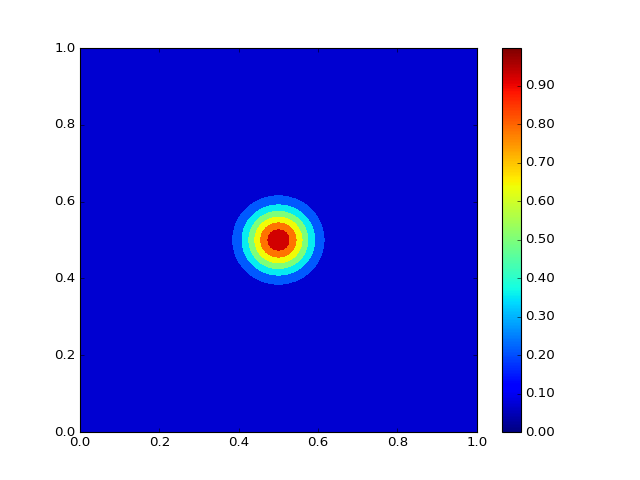

In [12]:
N=0
levels = numpy.linspace(numpy.amin(values[N]), numpy.amax(values[N]), 400)
fig = plt.figure()
ax = fig.add_subplot(111)
cs = ax.contourf(X,Y,values[N],levels=levels)

color = fig.colorbar(cs, ax=ax, format="%.2f")
anim = animation.FuncAnimation(fig,animate,frames = len(values),interval=50,blit=True)
plt.show()

In [13]:
a = numpy.matrix([[1,2,3],[1,2,3],[1,2,3]])


matrix([[1, 2, 3]])